<div style="border: none; margin: 5px 0; border-top: 1px dashed #FFFFFF; border-bottom: 1px dashed #FFFFFF; height: 5px;"></div>

<h2 style="color: #FFA07A;">3. Applying (Unsupervised) Algorithms to Select the Number of Clusters</h2>

In [1]:
import ipywidgets as widgets
import time
from IPython.display import display

# --- Create an HTML widget to display the typing effect ---
output = widgets.HTML(value="<div></div>")
display(output)

# --- HTML text with structure and style ---
text = """
<div style="background-color: #FFFFFF; color: #333333; padding: 15px; 
            border-left: 5px solid #FFA500; font-family: Arial, sans-serif; 
            text-align: justify; font-size: 16px; line-height: 1.6;">

    <b>After the initial data analysis, we now move on to the segmentation phase using <i>clustering</i> algorithms.</b> 

    <p><b>But first, it's important to understand a few concepts:</b></p>
    <p>🔸 <b>Spatial autocorrelation</b> indicates whether nearby areas have similar or different values regarding what we're studying (like access to services).</p>
    <p>🔸 It's related to <b>Tobler’s First Law of Geography</b>: <i>“Everything is related to everything else, but near things are more related than distant things.”</i></p>
    <p>🔸 If nearby locations have <b>similar values</b>, we say there is <b>positive autocorrelation</b> (they form clusters). If they are <b>different</b>, it's <b>negative</b> (indicating dispersion).</p>
    <p>🔸 Autocorrelation ranges from <b>-1 to +1</b>. A small <i>p</i>-value (e.g., &lt; 0.05) shows that the pattern is statistically significant — not due to chance.</p>

    <p><b>What is clustering?</b></p> 
    <p>🔸 It's a way of dividing data into groups (<i>clusters</i>) by grouping together similar observations.</p> 
    <p>🔸 We will test three methods: <b>K-Means</b>, <b>Gaussian Mixture Model (GMM)</b>, and <b>Agglomerative Clustering</b> to see how each one forms groups.</p> 
    <p>🔸 <b>K-Means</b> is fast and works well when clusters are well-separated. <b>GMM</b> allows some overlap between groups. <b>Agglomerative</b> is suitable when there's a hierarchical structure.</p> 
    <p>🔸 At the end, we'll compare the methods based on quality metrics.</p> 

    <p><b>Metrics used:</b></p>
    <ul> 
        <li><b>Silhouette Score</b>: measures how well each point fits within its cluster. Ranges from <b>-1 to 1</b>. The closer to <b>1</b>, the better. Scores near <b>0</b> or negative suggest poor or overlapping clusters.</li> 
        <li><b>Calinski-Harabasz Index</b>: measures how well the clusters are separated and how compact they are. <b>Higher values are better.</b></li> 
    </ul> 

    <p>🔸 To determine the ideal number of clusters, we use the <b>Elbow Method</b>. This method examines the <b>inertia</b>, i.e., the sum of distances between points and their cluster centers. When adding more clusters no longer significantly reduces inertia, we’ve found the “elbow” — the optimal number.</p> 

    <p><b>Additional metrics (GMM):</b></p>
    <ul> 
        <li><b>AIC (Akaike Information Criterion)</b>: helps choose the best number of clusters by balancing model quality and simplicity. Lower values indicate better models and penalize overly complex ones.</li> 
        <li><b>BIC (Bayesian Information Criterion)</b>: similar to AIC, but more conservative about complexity. Also favors lower values. The lower the BIC, the better the model fits the data without overfitting.</li> 
    </ul>

    <p>🔸 These two metrics are useful when using GMM because it's a probability-based model. They help identify if we’re using too many or too few clusters.</p>

    <p>🔸 We’ll also present 2D visualizations to help illustrate how each algorithm clustered the data, making comparisons easier.</p> 
</div>
"""

# --- Typing effect character by character (preserves HTML) ---
typed_text = ""
for char in text:
    typed_text += char
    output.value = typed_text
    time.sleep(0.005)  # Adjust speed if needed

# --- Final display to ensure full rendering ---
output.value = typed_text

HTML(value='<div></div>')

In [2]:
from IPython.display import Javascript, display
# hide-me
display(Javascript('window.cellVisibilityManager.hideCells();'))

# Run libraries
ipython = get_ipython()
ipython.run_line_magic("run", "case_study_prep.ipynb")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[INFO] Optimal number of clusters determined: 2                                 


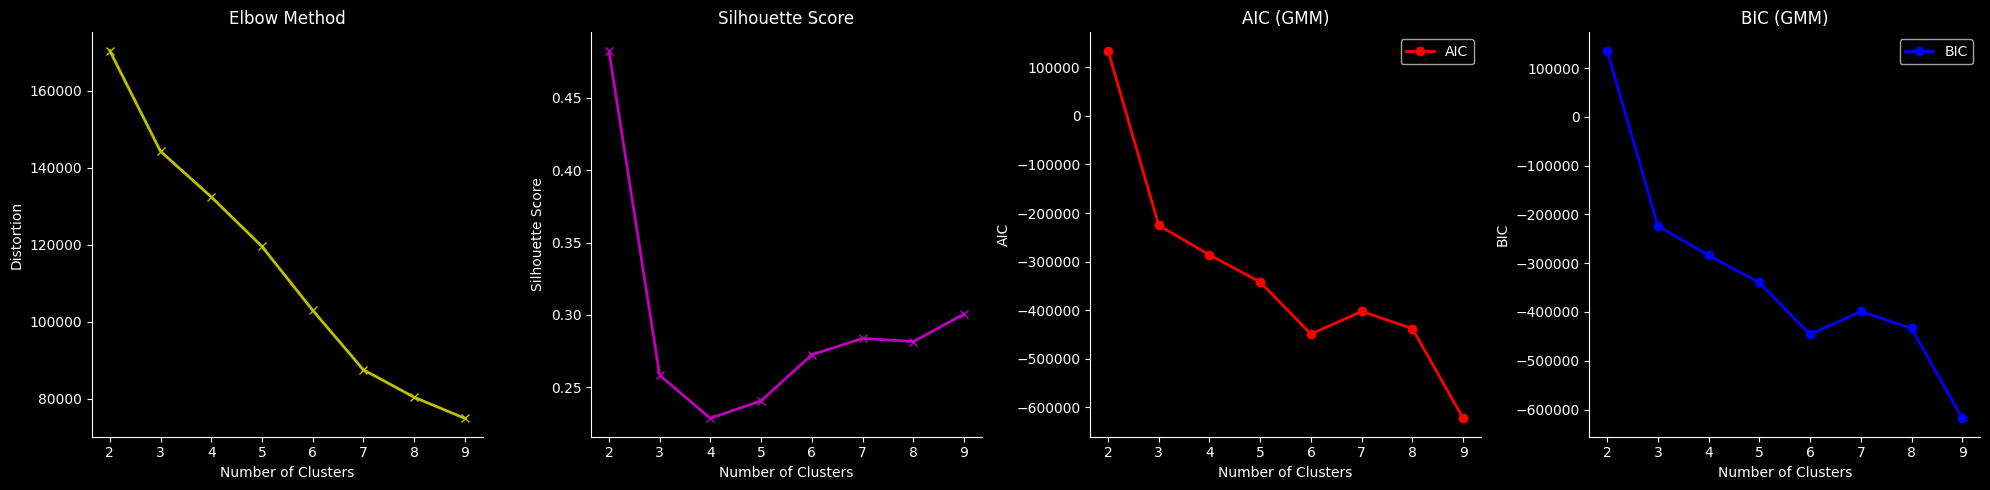

                                                                                
[INFO] Data processed successfully, displaying metrics and plots...


=== K-means ===
Silhouette Score: 0.483
Inertia: 170463.254
Calinski-Harabasz Index: 27720.987
Davies-Bouldin Index: 0.838

=== GMM ===
Silhouette Score: 0.476
Calinski-Harabasz Index: 25817.242
Davies-Bouldin Index: 0.820

=== Agglomerative Clustering ===
Silhouette Score: 0.481
Calinski-Harabasz Index: 27463.303
Davies-Bouldin Index: 0.845


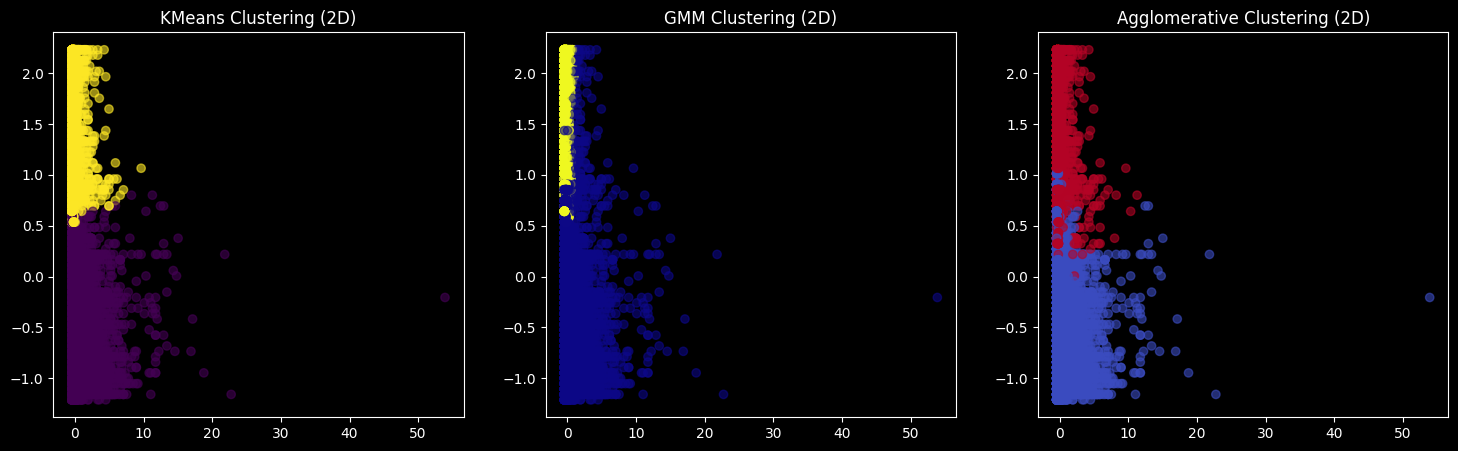

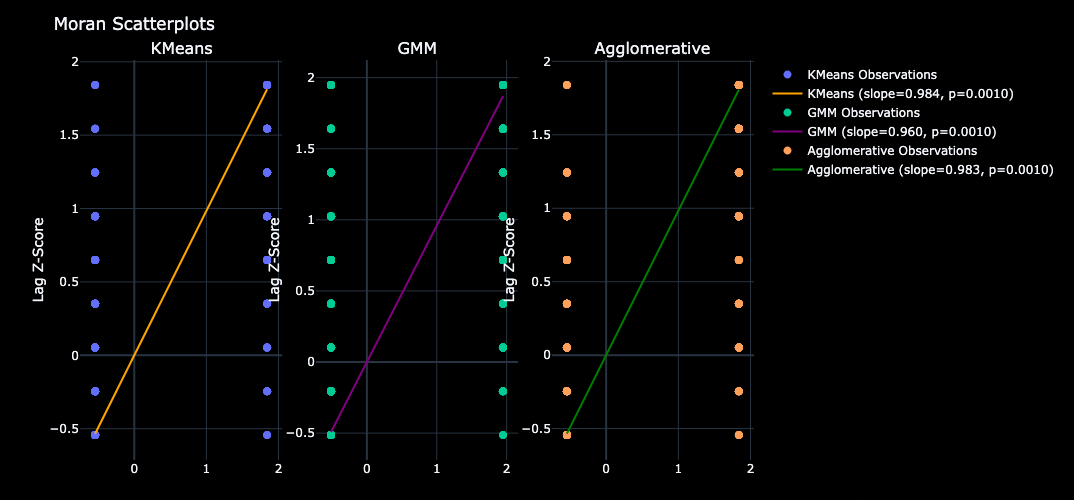

[INFO] After analysis, you may continue.


In [3]:
# hide-me
display(Javascript('window.cellVisibilityManager.hideCells();'))

warnings.filterwarnings("ignore", message="The weights matrix is not fully connected", module="libpysal.weights.distance")

# --- Load data ---
def clear_line():
    sys.stdout.write('\r' + ' ' * 80 + '\r')
    sys.stdout.flush()

input_pkl_path = "df_services.pkl"  # Update this path if your .pkl is elsewhere
with open(input_pkl_path, 'rb') as pkl_file:
    data = pickle.load(pkl_file)

df_services = data  # DataFrame as loaded

# Features in English (new columns from your updated files)
features = [
    'pop_65_plus', 'number_of_nearby_services', 'average_distance_to_services',
    'Health Centers', 'Pharmacies', 'Hospitals', 
    'Supermarkets', 'Banks', 'Parks and Gardens', 'Post Offices'
]

columns_to_keep = features + ['geometry']

# Drop rows with missing values
df_services = df_services.dropna(subset=features)

# Normalize the data
scaler = StandardScaler()
X = scaler.fit_transform(df_services[features])

# Temporary status message
sys.stdout.write("[INFO] Calculating clusters, please wait...\r")
sys.stdout.flush()

# --- Clustering and Evaluation Metrics ---
max_clusters = 10
distortions = []
silhouette_scores = []
aic_values, bic_values = [], []

for k in range(2, max_clusters):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    distortions.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X, kmeans.labels_))
    
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm.fit(X)
    aic_values.append(gmm.aic(X))
    bic_values.append(gmm.bic(X))

optimal_clusters = silhouette_scores.index(max(silhouette_scores)) + 2
clear_line()
print(f"[INFO] Optimal number of clusters determined: {optimal_clusters}")

# --- Plot elbow, silhouette, AIC, BIC ---
plt.style.use('dark_background')
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

for axis in ax:
    axis.spines['top'].set_visible(False)
    axis.spines['right'].set_visible(False)
    axis.spines['left'].set_color('white')
    axis.spines['bottom'].set_color('white')

ax[0].plot(range(2, max_clusters), distortions, 'yx-', linewidth=2)
ax[0].set_title('Elbow Method', color='white')
ax[0].set_xlabel('Number of Clusters', color='white')
ax[0].set_ylabel('Distortion', color='white')
ax[0].tick_params(axis='both', colors='white')

ax[1].plot(range(2, max_clusters), silhouette_scores, 'mx-', linewidth=2)
ax[1].set_title('Silhouette Score', color='white')
ax[1].set_xlabel('Number of Clusters', color='white')
ax[1].set_ylabel('Silhouette Score', color='white')
ax[1].tick_params(axis='both', colors='white')

ax[2].plot(range(2, max_clusters), aic_values, 'r-o', linewidth=2, label='AIC')
ax[2].set_title('AIC (GMM)', color='white')
ax[2].set_xlabel('Number of Clusters', color='white')
ax[2].set_ylabel('AIC', color='white')
ax[2].tick_params(axis='both', colors='white')
ax[2].legend()

ax[3].plot(range(2, max_clusters), bic_values, 'b-o', linewidth=2, label='BIC')
ax[3].set_title('BIC (GMM)', color='white')
ax[3].set_xlabel('Number of Clusters', color='white')
ax[3].set_ylabel('BIC', color='white')
ax[3].tick_params(axis='both', colors='white')
ax[3].legend()

plt.tight_layout()
plt.show()

# --- Final clustering ---
n_clusters = optimal_clusters
print(f"[INFO] Starting clustering with {n_clusters} clusters...", end='\r', flush=True)

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df_services['cluster_kmeans'] = kmeans.fit_predict(X)
centroids = kmeans.cluster_centers_

gmm = GaussianMixture(n_components=n_clusters, random_state=42)
df_services['cluster_gmm'] = gmm.fit_predict(X)

agglo = AgglomerativeClustering(n_clusters=n_clusters)
df_services['cluster_agglo'] = agglo.fit_predict(X)

# --- Metrics for each algorithm ---
silhouette_kmeans = silhouette_score(X, df_services['cluster_kmeans'])
inertia_kmeans = kmeans.inertia_
calinski_kmeans = calinski_harabasz_score(X, df_services['cluster_kmeans'])

silhouette_gmm = silhouette_score(X, df_services['cluster_gmm'])
calinski_gmm = calinski_harabasz_score(X, df_services['cluster_gmm'])

silhouette_agglo = silhouette_score(X, df_services['cluster_agglo'])
calinski_agglo = calinski_harabasz_score(X, df_services['cluster_agglo'])

dbi_kmeans = davies_bouldin_score(X, df_services['cluster_kmeans'])
dbi_gmm = davies_bouldin_score(X, df_services['cluster_gmm'])
dbi_agglo = davies_bouldin_score(X, df_services['cluster_agglo'])

# Output metrics
print(' ' * 80, end='\r')
print("\n[INFO] Data processed successfully, displaying metrics and plots...\n")

print("\n=== K-means ===")
print(f"Silhouette Score: {silhouette_kmeans:.3f}")
print(f"Inertia: {inertia_kmeans:.3f}")
print(f"Calinski-Harabasz Index: {calinski_kmeans:.3f}")
print(f"Davies-Bouldin Index: {dbi_kmeans:.3f}")

print("\n=== GMM ===")
print(f"Silhouette Score: {silhouette_gmm:.3f}")
print(f"Calinski-Harabasz Index: {calinski_gmm:.3f}")
print(f"Davies-Bouldin Index: {dbi_gmm:.3f}")

print("\n=== Agglomerative Clustering ===")
print(f"Silhouette Score: {silhouette_agglo:.3f}")
print(f"Calinski-Harabasz Index: {calinski_agglo:.3f}")
print(f"Davies-Bouldin Index: {dbi_agglo:.3f}")

# --- Final cluster visualizations (2D projections) ---
kmeans_labels = df_services['cluster_kmeans']
gmm_labels = df_services['cluster_gmm']
agglo_labels = df_services['cluster_agglo']

plt.style.use('dark_background')
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

ax[0].scatter(X[:, 0], X[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.6)
ax[0].set_title("KMeans Clustering (2D)")

ax[1].scatter(X[:, 0], X[:, 1], c=gmm_labels, cmap='plasma', alpha=0.6)
ax[1].set_title("GMM Clustering (2D)")

ax[2].scatter(X[:, 0], X[:, 1], c=agglo_labels, cmap='coolwarm', alpha=0.6)
ax[2].set_title("Agglomerative Clustering (2D)")

plt.show()

clear_line()

# --- Moran's I and scatterplots ---
if not isinstance(df_services, gpd.GeoDataFrame):
    df_services = gpd.GeoDataFrame(df_services, geometry='geometry')

def compute_moran_scatter(gdf, column, k=8):
    w = KNN.from_dataframe(gdf, k=k)
    w.transform = 'R'
    vals = gdf[column].values.astype(float)
    moran = Moran(vals, w)
    
    z = (vals - np.mean(vals)) / np.std(vals)
    lag_z = w.sparse.dot(z)
    
    line_x = np.linspace(z.min(), z.max(), 100)
    line_y = line_x * moran.I
    
    scatter_data = {
        "z": z,
        "z_lag": lag_z,
        "line_x": line_x,
        "line_y": line_y,
        "moran_I": moran.I,
        "p_value": moran.p_sim
    }
    return scatter_data

model_labels = {
    "KMeans": "cluster_kmeans",
    "GMM": "cluster_gmm",
    "Agglomerative": "cluster_agglo"
}
model_colors = {
    "KMeans": "orange",
    "GMM": "purple",
    "Agglomerative": "green"
}

results = {}
for model_name, col_cluster in model_labels.items():
    scatter = compute_moran_scatter(df_services, col_cluster, k=8)
    results[model_name] = {
        "moran_scatter": scatter,
        "moran_I": scatter["moran_I"],
        "p_value": scatter["p_value"]
    }

n_models = len(results)
fig_moran = make_subplots(
    rows=1, 
    cols=n_models, 
    subplot_titles=list(results.keys()),
    column_widths=[0.3, 0.3, 0.3],
    horizontal_spacing=0.05
)

col_idx = 1
for name, met in results.items():
    scatter = met["moran_scatter"]
    I = met["moran_I"]
    p = met["p_value"]
    line_color = model_colors.get(name, "white")
    fig_moran.add_trace(
        go.Scatter(
            x=scatter["z"],
            y=scatter["z_lag"],
            mode='markers',
            marker=dict(size=8),
            name=f"{name} Observations"
        ),
        row=1, col=col_idx
    )
    fig_moran.add_trace(
        go.Scatter(
            x=scatter["line_x"],
            y=scatter["line_y"],
            mode='lines',
            line=dict(color=line_color),
            name=f"{name} (slope={I:.3f}, p={p:.4f})"
        ),
        row=1, col=col_idx
    )
    fig_moran.update_yaxes(title_text="Lag Z-Score", title_standoff=1, row=1, col=col_idx)
    col_idx += 1

fig_moran.update_layout(
    width=1200,
    height=500,
    margin=dict(l=80, r=20, t=60, b=40),
    title='Moran Scatterplots',
    template='plotly_dark',
    plot_bgcolor='#000000',
    paper_bgcolor='#000000'
)
fig_moran.show()

# --- Save final DataFrame and metrics to .pkl file ---
metrics = {
    'KMeans': {
        'Silhouette Score': silhouette_kmeans,
        'Inertia': inertia_kmeans,
        'Calinski-Harabasz Index': calinski_kmeans,
        'Davies-Bouldin Index': dbi_kmeans
    },
    'GMM': {
        'Silhouette Score': silhouette_gmm,
        'Calinski-Harabasz Index': calinski_gmm,
        'Davies-Bouldin Index': dbi_gmm
    },
    'Agglomerative': {
        'Silhouette Score': silhouette_agglo,
        'Calinski-Harabasz Index': calinski_agglo,
        'Davies-Bouldin Index': dbi_agglo
    }
}

output_pkl_path = "data.pkl"
with open(output_pkl_path, 'wb') as pkl_file:
    pickle.dump({
        'df': df_services[columns_to_keep + ['cluster_kmeans', 'cluster_gmm', 'cluster_agglo']],
        'metrics': metrics
    }, pkl_file)

print("\033[92m[INFO] After analysis, you may continue.\033[0m")

<div style="border: none; margin: 5px 0; border-top: 1px dashed #FFFFFF; border-bottom: 1px dashed #FFFFFF; height: 5px;"></div>

<h2 style="color: #FFA07A;">3.1. Spatial Visualization of Clusters</h2>

In [6]:
import ipywidgets as widgets
import time
from IPython.display import display

# --- Create the HTML widget to display typing effect ---
output = widgets.HTML(value="<div></div>")
display(output)

# --- Formatted text ---
text = """
<div style="background-color: #FFFFFF; color: #333333; padding: 15px; 
            border-left: 5px solid #FFA500; font-family: Arial, sans-serif; 
            text-align: justify; font-size: 16px; line-height: 1.6;">

    <p>🔸 In the previous process, the algorithms produced similar results. However, the choice of <b><u>2 clusters</u></b> is supported by the evaluation metrics, suggesting the presence of two well-defined groups in the data.</p>

    <p>🔸 To better understand the spatial segmentation, the next section presents an interactive application that allows you to visualize the <i>clusters</i> generated by the three clustering algorithms (<b>K-Means, GMM, and Agglomerative Clustering</b>). In the panel, you can select the algorithm and the performance metric.</p>

    <p>🔸 After your analysis, answer the related question, keeping in mind that color variations in the building polygons reflect the clustering results. When a building polygon shows a different color within a <i>cluster</i>, it indicates that the algorithm had more difficulty correctly grouping the buildings in that area.</p>

</div>
"""

# --- Typing effect character-by-character while preserving HTML formatting ---
typed_text = ""
for char in text:
    typed_text += char
    output.value = typed_text
    time.sleep(0.005)  # Typing speed control

# --- Ensure the final text is fully displayed ---
output.value = typed_text

HTML(value='<div></div>')

In [3]:
# hide-me
display(Javascript('window.cellVisibilityManager.hideCells();'))

# --- Load DataFrame and metrics from .pkl file ---
input_pkl_path = "data.pkl"
with open(input_pkl_path, 'rb') as pkl_file:
    data = pickle.load(pkl_file)

df_services = data['df']      # DataFrame containing clusters and variables
metrics = data['metrics']     # Evaluation metrics for clustering models

# --- Check for the 'geometry' column (required for interactive map) ---
if 'geometry' not in df_services.columns:
    raise KeyError("The 'geometry' column is required to create the interactive map.")

# --- Initialize Dash app with external fonts ---
external_stylesheets = ['https://fonts.googleapis.com/css2?family=Roboto:wght@300;400;500&display=swap']
app_map = Dash(__name__, external_stylesheets=external_stylesheets)

# --- General styling ---
main_style = {
    'font-family': 'Roboto, sans-serif',
    'background-color': '#000',
    'color': 'white',
    'padding': '0',
    'margin': '0',
    'width': '100%',
    'box-sizing': 'border-box'
}

title_style = {
    'color': 'white',
    'background-color': '#000',
    'padding': '20px',
    'text-align': 'center',
    'font-size': '28px',
    'font-weight': '500',
    'border': '2px solid white',
    'border-radius': '10px',
    'margin-bottom': '20px',
    'box-shadow': '0px 4px 8px rgba(0, 0, 0, 0.2)'
}

container_style = {
    'display': 'flex',
    'justify-content': 'space-between',
    'align-items': 'center',
    'margin-bottom': '20px',
    'background-color': '#000',
    'padding': '15px',
    'border-radius': '10px',
    'box-shadow': '0px 4px 8px rgba(0, 0, 0, 0.2)'
}

component_style = {
    'background-color': '#000',
    'color': 'white',
    'border-radius': '5px',
    'border': '1px solid white',
    'width': '100%',
    'font-size': '16px'
}

# --- Dash Layout ---
app_map.index_string = '''
<!DOCTYPE html>
<html>
<head>
    <title>Interactive Map</title>
    <style>
        body, html {
            margin: 0;
            padding: 0;
            width: 100%;
            height: 100%;
            background-color: #2b2b2b;
        }
        iframe {
            border: none;
        }
    </style>
</head>
<body>
    {%app_entry%}
    <footer>
        {%config%}
        {%scripts%}
        {%renderer%}
    </footer>
</body>
</html>
'''

app_map.layout = html.Div([
    html.H1("Spatial visualization of clusters", style=title_style),

    html.Div([
        html.Div([
            html.Label("Select Clustering Algorithm:", style={'color': 'white', 'margin-bottom': '1px'}),
            dcc.Dropdown(
                id='model-dropdown',
                options=[
                    {'label': 'K-means', 'value': 'KMeans'},
                    {'label': 'Gaussian Mixture Model', 'value': 'GMM'},
                    {'label': 'Agglomerative Clustering', 'value': 'Agglomerative'}
                ],
                value='GMM',
                clearable=False,
                style={**component_style, 'color': 'black'}
            )
        ], style={'width': '30%', 'margin-right': '10px'}),

        html.Div([
            html.Label("Select Metric to Display:", style={'color': 'white', 'margin-bottom': '1px'}),
            dcc.Dropdown(
                id='metric-dropdown',
                options=[
                    {'label': 'Silhouette Score', 'value': 'silhouette'},
                    {'label': 'Calinski-Harabasz Index', 'value': 'calinski'}
                ],
                value='silhouette',
                clearable=False,
                style={**component_style, 'color': 'black'}
            )
        ], style={'width': '30%', 'margin-right': '10px'}),

        html.Div([
            html.Label("Selected Metric:", style={'color': 'white', 'margin-bottom': '1px'}),
            html.Div(id='metric-value', style={
                'color': 'white',
                'background-color': '#000',
                'border': '1px solid white',
                'border-radius': '8px',
                'padding': '8px',
                'font-size': '14px',
                'text-align': 'center',
                'width': '90%'
            })
        ], style={'width': '30%'})
    ], style=container_style),

    html.Div([
        html.Label("Interactive Map:", style={'color': 'white'}),
        html.Iframe(
            id='mapa-interativo',
            srcDoc=None,
            style={
                'width': '100%',
                'height': '600px',
                'margin': '0',
                'padding': '0',
                'border': 'none',
            }
        )
    ], style={'padding': '0', 'margin': '0'}),

    html.Div([
        html.Div([
            html.Div(style={'background-color': '#FF5733', 'width': '20px', 'height': '20px', 'display': 'inline-block', 'margin-right': '1px'}),
            html.Span("Cluster 0", style={'color': 'white', 'font-size': '14px'})
        ], style={'display': 'inline-block', 'margin-right': '20px'}),

        html.Div([
            html.Div(style={'background-color': '#33FF57', 'width': '20px', 'height': '20px', 'display': 'inline-block', 'margin-right': '1px'}),
            html.Span("Cluster 1", style={'color': 'white', 'font-size': '14px'})
        ], style={'display': 'inline-block'}),
    ], style={'margin-top': '20px', 'text-align': 'center'})
], style=main_style)

# --- Function to create the interactive map with 2 clusters ---
def create_interactive_map(df, cluster_column):
    map_ = folium.Map(location=[41.1390, -8.6291], zoom_start=13, min_zoom=13, tiles="CartoDB dark_matter", control_scale=True)
    cluster_colors = ['#FF0000', '#FFFFFF']

    for _, row in df.iterrows():
        polygon = row['geometry']
        cluster = row[cluster_column]
        color = cluster_colors[cluster % len(cluster_colors)]

        tooltip_text = f"""
            Cluster: {cluster}<br>
            Population 65+: {int(row['pop_65_plus'])}<br>
            Number of Nearby Services: {int(row['number_of_nearby_services'])}<br>
            Average Distance to Services: {int(row['average_distance_to_services'])}m
        """

        folium.GeoJson(
            data=polygon,
            style_function=lambda x, color=color: {'fillColor': color, 'color': '#333', 'weight': 0.5, 'fillOpacity': 0.6},
            tooltip=folium.Tooltip(tooltip_text)
        ).add_to(map_)

    return map_._repr_html_()

# --- Callback to update the map and display the selected metric ---
@app_map.callback(
    [Output('mapa-interativo', 'srcDoc'), Output('metric-value', 'children')],
    [Input('model-dropdown', 'value'), Input('metric-dropdown', 'value')]
)
def update_map(model_name, metric_name):
    if metric_name == 'silhouette':
        m = metrics[model_name]['Silhouette Score']
    else:
        m = metrics[model_name]['Calinski-Harabasz Index']
    metric_text = f"{metric_name.capitalize()}: {m:.3f}"

    model_to_col = {
        'KMeans'       : 'cluster_kmeans',
        'GMM'          : 'cluster_gmm',
        'Agglomerative': 'cluster_agglo'
    }
    cluster_column = model_to_col[model_name]

    map_html = create_interactive_map(df_services, cluster_column)
    return map_html, metric_text

print(f"[INFO] Please wait for the map. Data may take a few seconds to load after selecting options.")

# --- Find a free network port for the interactive dashboard ---
def find_free_port():
    while True:
        port = random.randint(8000, 9000)
        with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
            if s.connect_ex(("localhost", port)) != 0:
                return port

port = find_free_port()

if __name__ == '__main__':
    app_map.run(debug=False, port=port)

print("\033[92m[INFO] After analysis, you may continue.\033[0m")

<IPython.core.display.Javascript object>

[INFO] Please wait for the map. Data may take a few seconds to load after selecting options.


[INFO] After analysis, you may continue.


<div style="border: none; margin: 5px 0; border-top: 1px dashed #FFFFFF; border-bottom: 1px dashed #FFFFFF; height: 5px;"></div>

Next: [Explainable Artificial Intelligence - Clustering](explainable_ai_clustering.ipynb)

<div style="border: none; margin: 5px 0; border-top: 1px dashed #FFFFFF; border-bottom: 1px dashed #FFFFFF; height: 5px;"></div>